# Tweet Sentiment Analysis Project

by Garrett Williams, Dave McKinley and Ely Lin of Sphinx Consulting

## Overview

**Business Problem:**

In a world where technology startups are plentiful, consumer sentiment towards a brand can give us a lot of insights into their purchasing decisions, hence the financial performance of the company that makes them. Technology investment company WhiteOre have acquired our services to build them a predictive model that monitors recent tweets on technology products to help them make informed investment decisions. WhiteOre wants a generalizable model to gauge sentiment across different brands, to act as a filtering system to help decide which brands to investigate further for possible investment. WhiteOre only cares about whether people have positive emotions towards the brand because people buy things they like. 


**Target Audience:**

The hedge fund and private equity department of WhiteOre

**Context:**

False positive in this case would mean our model predicts that a consumer has positive emotions towards a brand but they actually don't, leading to overvaluing of a potential investment opportunity and wasting human capital.

False negative in this case would mean our model predicts that a consumer doesn't have positive emotions towards a brand but they actually do, leading to missing a potential investment opportunity.

**Evaluation:**

We don't want to overvalue or undervalue a company, however, the cost of missing the opportunity of getting in early on a good brand that's generating buzz is bigger than spending human resources to evaluate a company and finding out it's not worth investing in. Therefore, we care about maximizing accuracy as well as recall.

**Data Understanding:**

The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither. The tweets included are sent out during the South by South West conference in 2013, mostly about Google and Apple products.

Data source: https://data.world/crowdflower/brands-and-product-emotions

**Modeling**

We used nltk's tweet tokenizer to tokenize the tweets and tfidf vectorizer to vectorize them. 

Modeling techniques include logistic regression, decision trees, random forest, naive bayes, catboost and neural network. 

**Evaluation**

We are able to achieve above 70% accuracy on both training data and testing data on both our naive bayes and neural netword models without overfitting. However, naive bayes requires significantly less computational power so we decide to use naive bayes as our final model. 

## Business Understanding

## Data Understanding

In [30]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [31]:
# !pip install catboost

In [32]:
#load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [33]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head() #Sanity Check

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [34]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))
print(df.duplicated().sum())
print(("-"*20))
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
22
--------------------
Tweet           1
Product      5802
Sentiment       0
dtype: int64


In [35]:
#Simplify sentiment labels for visualizations
dict_sent = {'No emotion toward brand or product':"No emotion", 
             'Positive emotion':'Positive emotion',
             'Negative emotion':'Negative emotion',
             "I can't tell": "I can't tell"}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [36]:
#sentiment breakdown
df['Sentiment'].value_counts() 

No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: Sentiment, dtype: int64

In [37]:
#number of tweets per product
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [38]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [39]:
#drop duplicates
df.drop_duplicates(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [40]:
#drops Tweets with nonsensical characters
df.drop([6, 9092], inplace=True)

In [41]:
#reset the index after cleaning
df.reset_index(inplace=True)
df.drop(columns="index", inplace = True)

In [42]:
#looks at cleaned dataframe
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",NaN,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9067,"Google's Zeiger, a physician never reported po...",NaN,No emotion


In [43]:
#looks at remaining NaN's
print(df.isna().sum())

Tweet           0
Product      5787
Sentiment       0
dtype: int64


In [44]:
#Fills NaN's with "Undefined" to help with data visualizations
df['Product'].fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


In [45]:
#Fills NaN's with "Undefined" to help with data visualizations
df.Product.fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


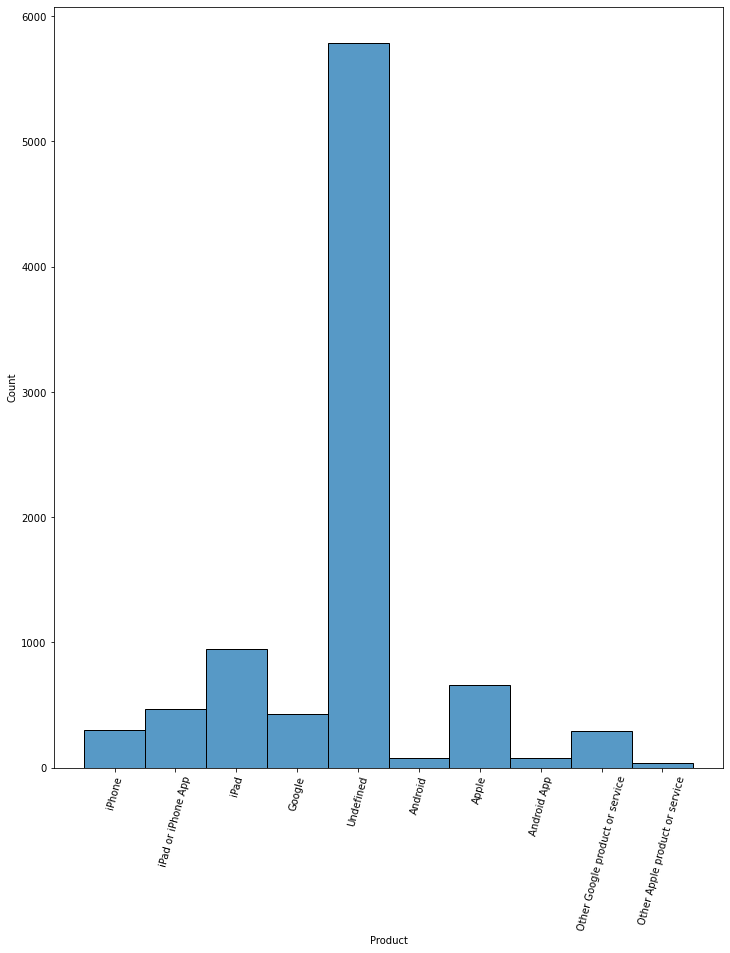

In [46]:
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product"] )
plt.xticks(rotation = 75)
plt.show()

In [47]:
#we are going to set the Product type as a string for our function below.
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9064             Undefined
9065                  iPad
9066             Undefined
9067             Undefined
9068             Undefined
Name: Product, Length: 9069, dtype: object

In [48]:
def find_brand(Product, Tweet):
    """
    This function is designed to take build a brand column based on the Product description. 
    After, the function will look at the Tweets and determine a brand for rows with no brand determined.
    
    Product -  a column teh function is working on
    Tweet - a column teh function is working on
    """
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [49]:
#Sanity Check
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [50]:
def countplot(df, col, hue=None, rotation=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = df[col].value_counts().index)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
    ax.set_title(f"Number of Tweets per {col}", fontsize = 30)
    plt.show()

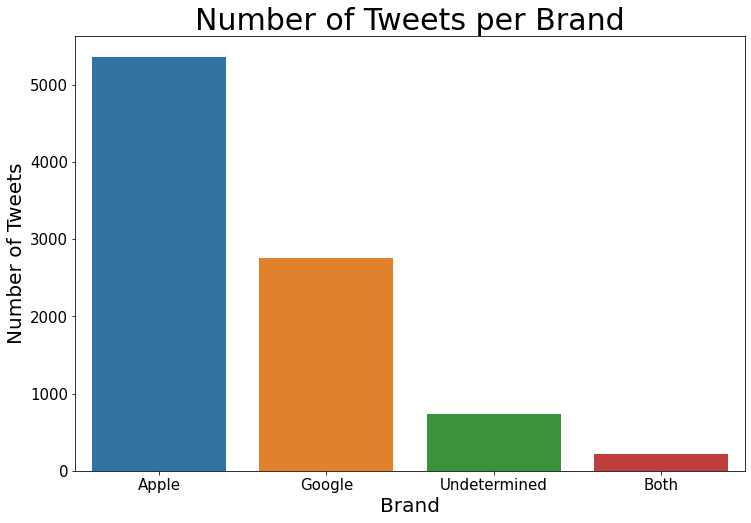

In [51]:
#countplot for Brand
countplot(df, "Brand")

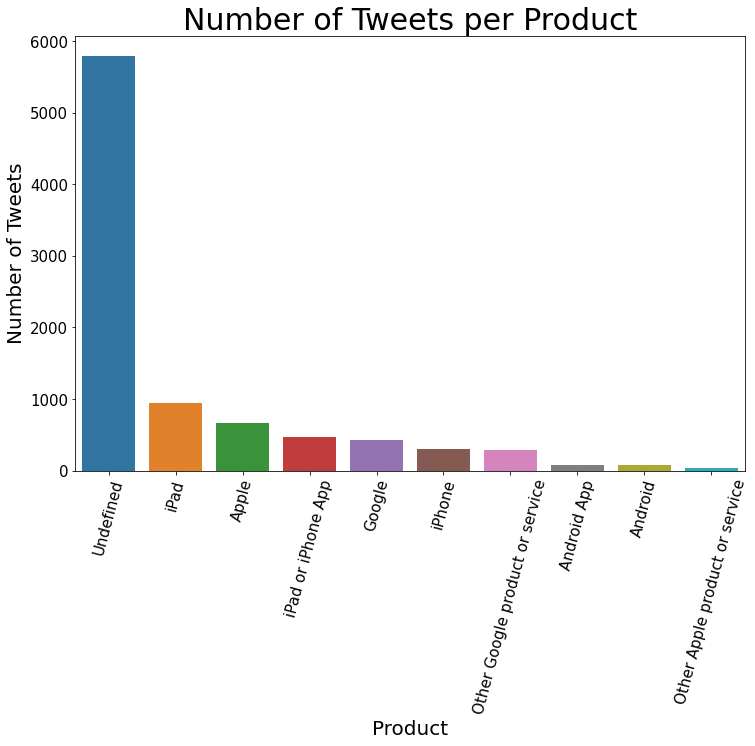

In [52]:
#countplot for Product
countplot(df, "Product", hue=None, rotation=75)

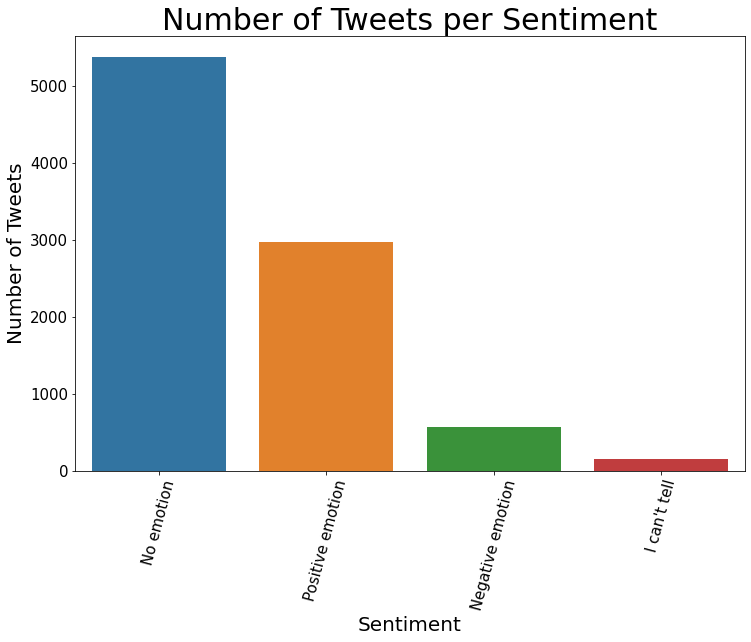

In [53]:
# Count plot for sentiment
countplot(df, "Sentiment", rotation = 75)

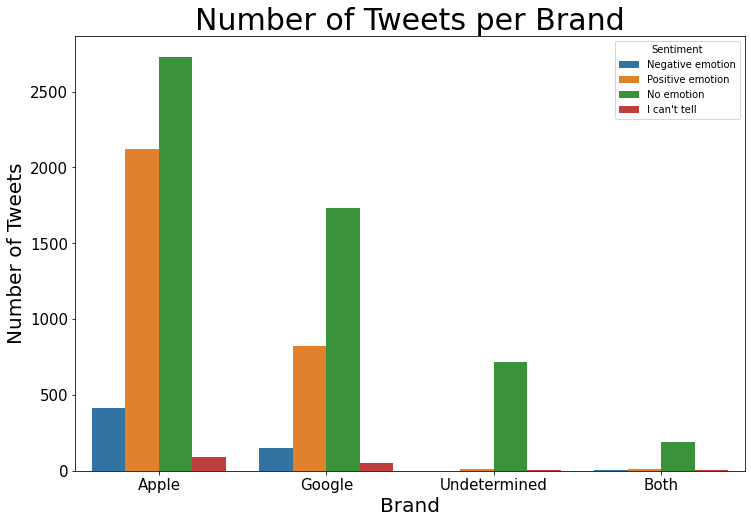

In [54]:
#count plot for Sentiment across brands
countplot(df, "Brand", hue = "Sentiment")

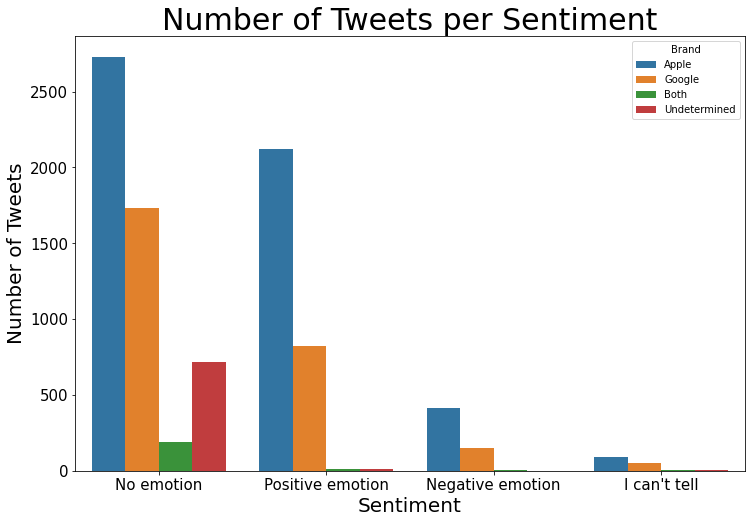

In [55]:
#countplot for brand make of sentiment
countplot(df, "Sentiment", hue="Brand")

In [56]:
#looking at the number of tweets per brand per sentiment
grouped = df.groupby(["Brand", "Sentiment"]).count()
grouped

Tweet  Product
Brand        Sentiment                       
Apple        I can't tell         93       93
             Negative emotion    415      415
             No emotion         2730     2730
             Positive emotion   2123     2123
Both         I can't tell          7        7
             Negative emotion      3        3
             No emotion          192      192
             Positive emotion     11       11
Google       I can't tell         50       50
             Negative emotion    150      150
             No emotion         1733     1733
             Positive emotion    823      823
Undetermined I can't tell          6        6
             Negative emotion      1        1
             No emotion          719      719
             Positive emotion     13       13

In [57]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment         Brand       
I can't tell      Apple           0.596154
                  Google          0.320513
                  Both            0.044872
                  Undetermined    0.038462
Negative emotion  Apple           0.729350
                  Google          0.263620
                  Both            0.005272
                  Undetermined    0.001757
No emotion        Apple           0.508001
                  Google          0.322479
                  Undetermined    0.133792
                  Both            0.035728
Positive emotion  Apple           0.714815
                  Google          0.277104
                  Undetermined    0.004377
                  Both            0.003704
Name: Brand, dtype: float64

------------------------------------------------------------


Brand         Sentiment       
Apple         No emotion          0.509233
              Positive emotion    0.396008
              Negative emotion    0.077411
              I can't tell        0.017348
Both          No emotion          0.901408
              Positive emotion    0.051643
              I can't tell        0.032864
              Negative emotion    0.014085
Google        No emotion          0.628810
              Positive emotion    0.298621
              Negative emotion    0.054427
              I can't tell        0.018142
Undetermined  No emotion          0.972936
              Positive emotion    0.017591
              I can't tell        0.008119
              Negative emotion    0.001353
Name: Sentiment, dtype: float64

In [58]:
#Number of Tweets per product
df["Product"].value_counts()

Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [59]:
#Number of Tweets per Sentiment
df["Sentiment"].value_counts()

No emotion          5374
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64

In [60]:
#Number of Tweet per Brand
df["Brand"].value_counts()

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [61]:
#Final DataFrame before Preprocessing
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


## Data Preprocessing

In [62]:
#Turn our Target into a Binary number
dict_sent = {'No emotion':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

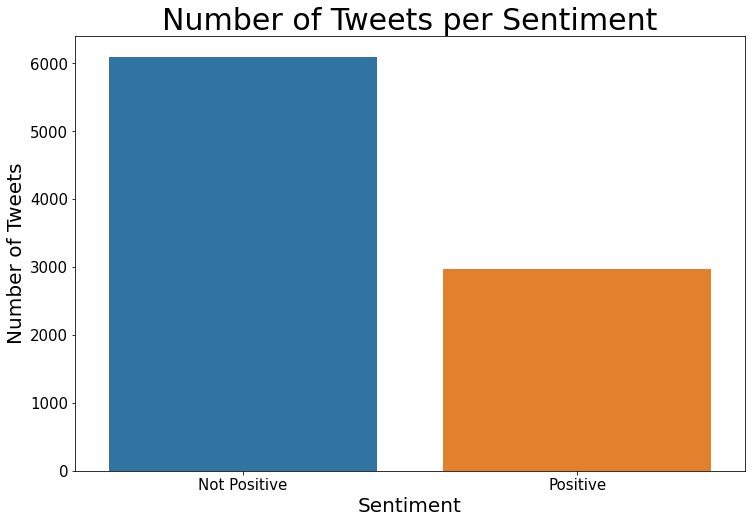

In [161]:
#Visualizing new Sentiment split
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data = df, x = "Sentiment", order = df["Sentiment"].value_counts().index)
ax.set_xticklabels(labels = ["Not Positive", "Positive"], fontsize = 15)
ax.set_xlabel(xlabel = "Sentiment", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
ax.set_title(f"Number of Tweets per Sentiment", fontsize = 30)
plt.show()

In [130]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Doing the train-test split before the Data Preprocessing prevents data leakage.

In [64]:
#Baseline Understanding
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [132]:
#Check first few rows in X_train
X_train["Tweet"].iloc[5622]

'@mention RT: New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable {link}'

In [66]:
#Check how many rows X_train has
X_train.shape

(6121, 1)

In [135]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
stopwords_list.append("link")
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [136]:
def clean_tweets(text):
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

In [137]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[5622])

'new ubersocial iphone app store includes uberguide sponsored mashable'

In [70]:
#Apply our clean_tweets function to X_train, X_val, X_test
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_53124/2577958706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_53124/2577958706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))


In [129]:
#Sanity Check
X_train

2320         make iphone case ttye time want show support
5622    come party google tonight link band food art i...
1748    winning winning gave away red mophie juice pac...
5789    google facebook official death policy vast maj...
3334    rumor google launching new social network call...
                              ...                        
5692      even security guard austin enjoy ipad time link
8582    attending want explore austin check austin lin...
7815               apple popup store link gonnagetanipad2
7483    putting pop apple store smart talk understandi...
3531    thought path iphone photo app iphoneography mo...
Name: Tweet, Length: 6121, dtype: object

In [72]:
y_train

2320    0
5622    1
1748    0
5789    0
3334    0
       ..
5692    1
8582    0
7815    0
7483    1
3531    0
Name: Sentiment, Length: 6121, dtype: int64

In [73]:
X_val

,Tweet
888,hootsuite mobile update iphone blackberry andr...
4191,morning hearing google circle today link
2161,great location choice nice timing ipad launch ...
1882,win ipad via link
4693,launching product plenty else join h4ckers 80 ...
...,...
1030,racing around best fueling great local fare ea...
4179,omg still line new ipad dieing hunger else line
7714,hour popup apple store lone security guard enj...
8190,great app interface example moma target flipbo...


In [74]:
y_val

888     0
4191    0
2161    1
1882    1
4693    0
       ..
1030    0
4179    1
7714    0
8190    1
4510    0
Name: Sentiment, Length: 2041, dtype: int64

## Modeling

### 1st Iteration: Simple Naive Bayes

In [138]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
cv_nb = cross_validate(pipe_nb, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb

{'fit_time': array([0.37702799, 0.31202793, 0.32257915, 0.24694729, 0.25001884]),
 'score_time': array([0.11800909, 0.18376827, 0.1630125 , 0.15801287, 0.09700823]),
 'test_accuracy': array([0.69877551, 0.69852941, 0.70179739, 0.69281046, 0.70098039]),
 'train_accuracy': array([0.75183824, 0.7606698 , 0.75597304, 0.75740249, 0.75536042]),
 'test_recall': array([0.0906801 , 0.0959596 , 0.08838384, 0.08585859, 0.1010101 ]),
 'train_recall': array([0.23926768, 0.26687697, 0.25488959, 0.25804416, 0.25047319]),
 'test_roc_auc': array([0.72439735, 0.67681342, 0.6973616 , 0.70740314, 0.70328893]),
 'train_roc_auc': array([0.88430891, 0.89357341, 0.88710149, 0.88794175, 0.88712882])}

In [139]:
#Get mean accuracy for validation set
cv_nb['test_accuracy'].mean()

0.698578631452581

In [143]:
pipe_nb.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('nb', MultinomialNB())])

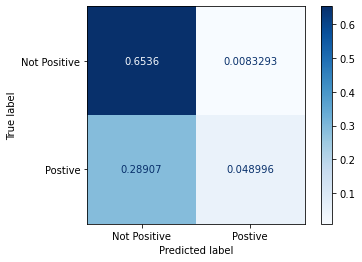

In [144]:
plot_confusion_matrix(pipe_nb, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 2nd Iteration: Naive Bayes with a tuned TfidfVectorizer

In [80]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
pipe_nb_tuned = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.003, max_features=1000)),
    ('nb_tuned', MultinomialNB(alpha=.1))
])
#Cross validate
cv_nb_tuned = cross_validate(pipe_nb_tuned, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb_tuned

{'fit_time': array([0.26501727, 0.21901631, 0.23002982, 0.24101901, 0.22702622]),
 'score_time': array([0.12501478, 0.12219524, 0.11167622, 0.1220119 , 0.11300445]),
 'test_accuracy': array([0.72897959, 0.70506536, 0.72222222, 0.69444444, 0.71568627]),
 'train_accuracy': array([0.73897059, 0.74555851, 0.73187666, 0.74310803, 0.73514397]),
 'test_recall': array([0.26448363, 0.23989899, 0.25757576, 0.23737374, 0.22222222]),
 'train_recall': array([0.30239899, 0.31861199, 0.27003155, 0.31167192, 0.28769716]),
 'test_roc_auc': array([0.71332701, 0.67444981, 0.68969435, 0.6784893 , 0.67984647]),
 'train_roc_auc': array([0.76477105, 0.77150663, 0.76517844, 0.76901536, 0.76902355])}

In [81]:
#Get mean accuracy for validation set
cv_nb_tuned['test_accuracy'].mean()

0.713279578498066

In [82]:
pipe_nb_tuned.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer_tuned',
                 TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.003)),
                ('nb_tuned', MultinomialNB(alpha=0.1))])

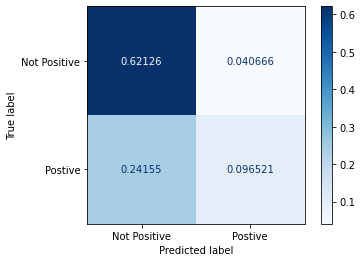

In [84]:
plot_confusion_matrix(pipe_nb_tuned, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 3rd Iteration: Logistic Regression with PCA

In [145]:
#Create a tuned tfidf vectorizer that will be scaled for PCA
tfidf_vectorizer_tuned = TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)

#Fit vectorizer on X_train
tfidf_vectorizer_tuned.fit(X_train['Tweet'])

#Transform X_train and X_val
X_train_tfidf_vec = tfidf_vectorizer_tuned.transform(X_train['Tweet'])
X_val_tfidf_vec = tfidf_vectorizer_tuned.transform(X_val['Tweet'])

#Turn X_train and X_val into DataFrame
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())

In [146]:
#Create a StandardScaler Object
scaler = StandardScaler()

#Fit scaler to tuned vectorized X_train and transform both X_train and X_val
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df)
X_val_scaled = scaler.transform(X_val_tfidf_vec_df)

In [147]:
#Create a PCA object
pca = PCA(n_components = .99, random_state=42)

In [148]:
#Create a Pipeline object for PCA and Logistic Regression
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [149]:
#Check results
print("PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes
0.7500408429995099
0.7070063694267515


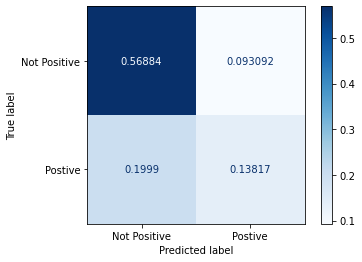

In [150]:
plot_confusion_matrix(pipe_lr, X_val_scaled, y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 4th Iteration: CatBoost

In [93]:
#Create a pipeline with CatBoost
pipe_cbc = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer(max_df=.99,min_df=0.0005, max_features=1000)),
    ('cbc', CatBoostClassifier())
])
#Cross Validate
cv_cbc = cross_validate(pipe_cbc, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
cv_cbc

Learning rate set to 0.0203
0:	learn: 0.6902882	total: 117ms	remaining: 1m 57s
1:	learn: 0.6873132	total: 163ms	remaining: 1m 21s
2:	learn: 0.6846064	total: 207ms	remaining: 1m 8s
3:	learn: 0.6819889	total: 249ms	remaining: 1m 1s
4:	learn: 0.6794833	total: 280ms	remaining: 55.8s
5:	learn: 0.6766114	total: 310ms	remaining: 51.4s
6:	learn: 0.6740722	total: 338ms	remaining: 48s
7:	learn: 0.6720902	total: 370ms	remaining: 45.9s
8:	learn: 0.6694389	total: 402ms	remaining: 44.3s
9:	learn: 0.6673317	total: 437ms	remaining: 43.2s
10:	learn: 0.6650526	total: 471ms	remaining: 42.3s
11:	learn: 0.6630197	total: 504ms	remaining: 41.5s
12:	learn: 0.6611200	total: 537ms	remaining: 40.8s
13:	learn: 0.6592143	total: 573ms	remaining: 40.3s
14:	learn: 0.6574584	total: 606ms	remaining: 39.8s
15:	learn: 0.6557285	total: 638ms	remaining: 39.3s
16:	learn: 0.6541164	total: 666ms	remaining: 38.5s
17:	learn: 0.6525168	total: 696ms	remaining: 37.9s
18:	learn: 0.6509141	total: 728ms	remaining: 37.6s
19:	learn: 0.

162:	learn: 0.5790983	total: 5.21s	remaining: 26.7s
163:	learn: 0.5788402	total: 5.24s	remaining: 26.7s
164:	learn: 0.5786935	total: 5.28s	remaining: 26.7s
165:	learn: 0.5785465	total: 5.31s	remaining: 26.7s
166:	learn: 0.5783247	total: 5.35s	remaining: 26.7s
167:	learn: 0.5781191	total: 5.38s	remaining: 26.7s
168:	learn: 0.5779478	total: 5.42s	remaining: 26.7s
169:	learn: 0.5777905	total: 5.46s	remaining: 26.7s
170:	learn: 0.5775882	total: 5.49s	remaining: 26.6s
171:	learn: 0.5773660	total: 5.52s	remaining: 26.6s
172:	learn: 0.5771762	total: 5.55s	remaining: 26.5s
173:	learn: 0.5770290	total: 5.58s	remaining: 26.5s
174:	learn: 0.5768644	total: 5.61s	remaining: 26.4s
175:	learn: 0.5766318	total: 5.64s	remaining: 26.4s
176:	learn: 0.5764919	total: 5.67s	remaining: 26.4s
177:	learn: 0.5762742	total: 5.7s	remaining: 26.3s
178:	learn: 0.5760944	total: 5.72s	remaining: 26.2s
179:	learn: 0.5758851	total: 5.75s	remaining: 26.2s
180:	learn: 0.5757540	total: 5.79s	remaining: 26.2s
181:	learn: 0

322:	learn: 0.5540584	total: 10.6s	remaining: 22.2s
323:	learn: 0.5539100	total: 10.6s	remaining: 22.1s
324:	learn: 0.5537937	total: 10.6s	remaining: 22.1s
325:	learn: 0.5535959	total: 10.7s	remaining: 22.1s
326:	learn: 0.5534536	total: 10.7s	remaining: 22s
327:	learn: 0.5533161	total: 10.7s	remaining: 22s
328:	learn: 0.5531873	total: 10.8s	remaining: 21.9s
329:	learn: 0.5530725	total: 10.8s	remaining: 21.9s
330:	learn: 0.5529600	total: 10.8s	remaining: 21.9s
331:	learn: 0.5527996	total: 10.9s	remaining: 21.8s
332:	learn: 0.5526661	total: 10.9s	remaining: 21.8s
333:	learn: 0.5525531	total: 10.9s	remaining: 21.8s
334:	learn: 0.5524214	total: 10.9s	remaining: 21.7s
335:	learn: 0.5521781	total: 11s	remaining: 21.7s
336:	learn: 0.5520488	total: 11s	remaining: 21.6s
337:	learn: 0.5519263	total: 11s	remaining: 21.6s
338:	learn: 0.5517800	total: 11.1s	remaining: 21.6s
339:	learn: 0.5516121	total: 11.1s	remaining: 21.5s
340:	learn: 0.5514041	total: 11.1s	remaining: 21.5s
341:	learn: 0.5512612	

486:	learn: 0.5299691	total: 16s	remaining: 16.8s
487:	learn: 0.5298644	total: 16s	remaining: 16.8s
488:	learn: 0.5297574	total: 16s	remaining: 16.8s
489:	learn: 0.5295836	total: 16.1s	remaining: 16.7s
490:	learn: 0.5293278	total: 16.1s	remaining: 16.7s
491:	learn: 0.5292087	total: 16.1s	remaining: 16.7s
492:	learn: 0.5290549	total: 16.2s	remaining: 16.6s
493:	learn: 0.5289207	total: 16.2s	remaining: 16.6s
494:	learn: 0.5287973	total: 16.2s	remaining: 16.6s
495:	learn: 0.5286839	total: 16.3s	remaining: 16.5s
496:	learn: 0.5284810	total: 16.3s	remaining: 16.5s
497:	learn: 0.5283838	total: 16.3s	remaining: 16.5s
498:	learn: 0.5282806	total: 16.4s	remaining: 16.4s
499:	learn: 0.5281344	total: 16.4s	remaining: 16.4s
500:	learn: 0.5280174	total: 16.4s	remaining: 16.4s
501:	learn: 0.5278460	total: 16.5s	remaining: 16.3s
502:	learn: 0.5277381	total: 16.5s	remaining: 16.3s
503:	learn: 0.5276316	total: 16.5s	remaining: 16.3s
504:	learn: 0.5275100	total: 16.6s	remaining: 16.2s
505:	learn: 0.5273

647:	learn: 0.5058952	total: 21.2s	remaining: 11.5s
648:	learn: 0.5057353	total: 21.2s	remaining: 11.5s
649:	learn: 0.5055218	total: 21.3s	remaining: 11.5s
650:	learn: 0.5053608	total: 21.3s	remaining: 11.4s
651:	learn: 0.5052155	total: 21.3s	remaining: 11.4s
652:	learn: 0.5050833	total: 21.4s	remaining: 11.4s
653:	learn: 0.5049812	total: 21.4s	remaining: 11.3s
654:	learn: 0.5047877	total: 21.4s	remaining: 11.3s
655:	learn: 0.5046418	total: 21.5s	remaining: 11.3s
656:	learn: 0.5044981	total: 21.5s	remaining: 11.2s
657:	learn: 0.5043681	total: 21.5s	remaining: 11.2s
658:	learn: 0.5043056	total: 21.6s	remaining: 11.2s
659:	learn: 0.5041918	total: 21.6s	remaining: 11.1s
660:	learn: 0.5040121	total: 21.6s	remaining: 11.1s
661:	learn: 0.5039000	total: 21.7s	remaining: 11.1s
662:	learn: 0.5038199	total: 21.7s	remaining: 11s
663:	learn: 0.5036599	total: 21.7s	remaining: 11s
664:	learn: 0.5034596	total: 21.8s	remaining: 11s
665:	learn: 0.5033199	total: 21.8s	remaining: 10.9s
666:	learn: 0.5030

808:	learn: 0.4846011	total: 26.6s	remaining: 6.28s
809:	learn: 0.4845097	total: 26.6s	remaining: 6.24s
810:	learn: 0.4843450	total: 26.7s	remaining: 6.21s
811:	learn: 0.4841981	total: 26.7s	remaining: 6.18s
812:	learn: 0.4841037	total: 26.7s	remaining: 6.15s
813:	learn: 0.4839557	total: 26.8s	remaining: 6.12s
814:	learn: 0.4838373	total: 26.8s	remaining: 6.08s
815:	learn: 0.4837456	total: 26.8s	remaining: 6.05s
816:	learn: 0.4836818	total: 26.9s	remaining: 6.02s
817:	learn: 0.4836239	total: 26.9s	remaining: 5.98s
818:	learn: 0.4835664	total: 26.9s	remaining: 5.95s
819:	learn: 0.4834666	total: 27s	remaining: 5.92s
820:	learn: 0.4834029	total: 27s	remaining: 5.88s
821:	learn: 0.4832362	total: 27s	remaining: 5.85s
822:	learn: 0.4830222	total: 27.1s	remaining: 5.82s
823:	learn: 0.4829583	total: 27.1s	remaining: 5.79s
824:	learn: 0.4828659	total: 27.1s	remaining: 5.75s
825:	learn: 0.4827875	total: 27.2s	remaining: 5.72s
826:	learn: 0.4826037	total: 27.2s	remaining: 5.69s
827:	learn: 0.4824

970:	learn: 0.4666292	total: 32s	remaining: 956ms
971:	learn: 0.4665834	total: 32s	remaining: 923ms
972:	learn: 0.4665072	total: 32.1s	remaining: 890ms
973:	learn: 0.4663829	total: 32.1s	remaining: 856ms
974:	learn: 0.4662638	total: 32.1s	remaining: 823ms
975:	learn: 0.4660506	total: 32.1s	remaining: 790ms
976:	learn: 0.4659687	total: 32.2s	remaining: 757ms
977:	learn: 0.4659350	total: 32.2s	remaining: 724ms
978:	learn: 0.4657990	total: 32.2s	remaining: 691ms
979:	learn: 0.4656253	total: 32.3s	remaining: 658ms
980:	learn: 0.4654539	total: 32.3s	remaining: 625ms
981:	learn: 0.4652905	total: 32.3s	remaining: 592ms
982:	learn: 0.4652310	total: 32.3s	remaining: 559ms
983:	learn: 0.4650690	total: 32.4s	remaining: 526ms
984:	learn: 0.4649635	total: 32.4s	remaining: 493ms
985:	learn: 0.4647946	total: 32.4s	remaining: 460ms
986:	learn: 0.4646975	total: 32.5s	remaining: 427ms
987:	learn: 0.4645670	total: 32.5s	remaining: 395ms
988:	learn: 0.4644758	total: 32.5s	remaining: 362ms
989:	learn: 0.46

130:	learn: 0.5859282	total: 4.35s	remaining: 28.9s
131:	learn: 0.5856288	total: 4.38s	remaining: 28.8s
132:	learn: 0.5853891	total: 4.42s	remaining: 28.8s
133:	learn: 0.5851525	total: 4.45s	remaining: 28.8s
134:	learn: 0.5849308	total: 4.49s	remaining: 28.8s
135:	learn: 0.5846463	total: 4.53s	remaining: 28.8s
136:	learn: 0.5843977	total: 4.56s	remaining: 28.8s
137:	learn: 0.5841369	total: 4.61s	remaining: 28.8s
138:	learn: 0.5839330	total: 4.64s	remaining: 28.8s
139:	learn: 0.5837104	total: 4.68s	remaining: 28.7s
140:	learn: 0.5834963	total: 4.71s	remaining: 28.7s
141:	learn: 0.5833442	total: 4.74s	remaining: 28.6s
142:	learn: 0.5831277	total: 4.77s	remaining: 28.6s
143:	learn: 0.5828636	total: 4.8s	remaining: 28.5s
144:	learn: 0.5826130	total: 4.83s	remaining: 28.5s
145:	learn: 0.5824469	total: 4.86s	remaining: 28.4s
146:	learn: 0.5821659	total: 4.89s	remaining: 28.4s
147:	learn: 0.5818952	total: 4.92s	remaining: 28.3s
148:	learn: 0.5817046	total: 4.94s	remaining: 28.2s
149:	learn: 0

291:	learn: 0.5563771	total: 9.51s	remaining: 23.1s
292:	learn: 0.5561411	total: 9.54s	remaining: 23s
293:	learn: 0.5559168	total: 9.57s	remaining: 23s
294:	learn: 0.5557318	total: 9.6s	remaining: 22.9s
295:	learn: 0.5555790	total: 9.64s	remaining: 22.9s
296:	learn: 0.5554211	total: 9.67s	remaining: 22.9s
297:	learn: 0.5552391	total: 9.7s	remaining: 22.8s
298:	learn: 0.5550903	total: 9.73s	remaining: 22.8s
299:	learn: 0.5548548	total: 9.76s	remaining: 22.8s
300:	learn: 0.5546878	total: 9.79s	remaining: 22.7s
301:	learn: 0.5545705	total: 9.82s	remaining: 22.7s
302:	learn: 0.5542992	total: 9.85s	remaining: 22.7s
303:	learn: 0.5541753	total: 9.88s	remaining: 22.6s
304:	learn: 0.5540256	total: 9.9s	remaining: 22.6s
305:	learn: 0.5539166	total: 9.94s	remaining: 22.5s
306:	learn: 0.5538111	total: 9.96s	remaining: 22.5s
307:	learn: 0.5536616	total: 10s	remaining: 22.5s
308:	learn: 0.5535449	total: 10s	remaining: 22.4s
309:	learn: 0.5534186	total: 10.1s	remaining: 22.4s
310:	learn: 0.5533115	t

451:	learn: 0.5333200	total: 14.8s	remaining: 17.9s
452:	learn: 0.5331878	total: 14.8s	remaining: 17.9s
453:	learn: 0.5330185	total: 14.9s	remaining: 17.9s
454:	learn: 0.5328132	total: 14.9s	remaining: 17.9s
455:	learn: 0.5326110	total: 14.9s	remaining: 17.8s
456:	learn: 0.5325145	total: 15s	remaining: 17.8s
457:	learn: 0.5323323	total: 15s	remaining: 17.8s
458:	learn: 0.5321872	total: 15.1s	remaining: 17.8s
459:	learn: 0.5319990	total: 15.1s	remaining: 17.7s
460:	learn: 0.5318318	total: 15.1s	remaining: 17.7s
461:	learn: 0.5316836	total: 15.2s	remaining: 17.7s
462:	learn: 0.5314699	total: 15.2s	remaining: 17.6s
463:	learn: 0.5312753	total: 15.2s	remaining: 17.6s
464:	learn: 0.5310962	total: 15.3s	remaining: 17.6s
465:	learn: 0.5308554	total: 15.3s	remaining: 17.5s
466:	learn: 0.5307132	total: 15.3s	remaining: 17.5s
467:	learn: 0.5305828	total: 15.4s	remaining: 17.5s
468:	learn: 0.5304934	total: 15.4s	remaining: 17.4s
469:	learn: 0.5303650	total: 15.4s	remaining: 17.4s
470:	learn: 0.53

610:	learn: 0.5084213	total: 20.3s	remaining: 12.9s
611:	learn: 0.5082645	total: 20.4s	remaining: 12.9s
612:	learn: 0.5081901	total: 20.4s	remaining: 12.9s
613:	learn: 0.5080491	total: 20.4s	remaining: 12.8s
614:	learn: 0.5079189	total: 20.5s	remaining: 12.8s
615:	learn: 0.5077034	total: 20.5s	remaining: 12.8s
616:	learn: 0.5075212	total: 20.5s	remaining: 12.7s
617:	learn: 0.5073809	total: 20.6s	remaining: 12.7s
618:	learn: 0.5071333	total: 20.6s	remaining: 12.7s
619:	learn: 0.5070135	total: 20.6s	remaining: 12.6s
620:	learn: 0.5068741	total: 20.7s	remaining: 12.6s
621:	learn: 0.5067171	total: 20.7s	remaining: 12.6s
622:	learn: 0.5066430	total: 20.7s	remaining: 12.5s
623:	learn: 0.5064672	total: 20.8s	remaining: 12.5s
624:	learn: 0.5062570	total: 20.8s	remaining: 12.5s
625:	learn: 0.5061722	total: 20.8s	remaining: 12.4s
626:	learn: 0.5060342	total: 20.8s	remaining: 12.4s
627:	learn: 0.5057383	total: 20.9s	remaining: 12.4s
628:	learn: 0.5056067	total: 20.9s	remaining: 12.3s
629:	learn: 

769:	learn: 0.4862644	total: 25.8s	remaining: 7.7s
770:	learn: 0.4860740	total: 25.8s	remaining: 7.67s
771:	learn: 0.4859289	total: 25.9s	remaining: 7.63s
772:	learn: 0.4857959	total: 25.9s	remaining: 7.6s
773:	learn: 0.4857248	total: 25.9s	remaining: 7.57s
774:	learn: 0.4856780	total: 25.9s	remaining: 7.53s
775:	learn: 0.4855367	total: 26s	remaining: 7.5s
776:	learn: 0.4854595	total: 26s	remaining: 7.46s
777:	learn: 0.4852835	total: 26s	remaining: 7.43s
778:	learn: 0.4849757	total: 26.1s	remaining: 7.4s
779:	learn: 0.4849366	total: 26.1s	remaining: 7.36s
780:	learn: 0.4847893	total: 26.1s	remaining: 7.33s
781:	learn: 0.4846842	total: 26.2s	remaining: 7.29s
782:	learn: 0.4845380	total: 26.2s	remaining: 7.26s
783:	learn: 0.4843662	total: 26.2s	remaining: 7.22s
784:	learn: 0.4842876	total: 26.3s	remaining: 7.19s
785:	learn: 0.4842043	total: 26.3s	remaining: 7.16s
786:	learn: 0.4841340	total: 26.3s	remaining: 7.12s
787:	learn: 0.4840824	total: 26.3s	remaining: 7.09s
788:	learn: 0.4838333	

933:	learn: 0.4668791	total: 31.5s	remaining: 2.23s
934:	learn: 0.4667424	total: 31.5s	remaining: 2.19s
935:	learn: 0.4666867	total: 31.5s	remaining: 2.16s
936:	learn: 0.4664743	total: 31.6s	remaining: 2.12s
937:	learn: 0.4663493	total: 31.6s	remaining: 2.09s
938:	learn: 0.4661694	total: 31.6s	remaining: 2.06s
939:	learn: 0.4660328	total: 31.7s	remaining: 2.02s
940:	learn: 0.4658304	total: 31.7s	remaining: 1.99s
941:	learn: 0.4656639	total: 31.7s	remaining: 1.95s
942:	learn: 0.4655193	total: 31.8s	remaining: 1.92s
943:	learn: 0.4654506	total: 31.8s	remaining: 1.89s
944:	learn: 0.4653794	total: 31.9s	remaining: 1.85s
945:	learn: 0.4652097	total: 31.9s	remaining: 1.82s
946:	learn: 0.4651628	total: 31.9s	remaining: 1.79s
947:	learn: 0.4650905	total: 31.9s	remaining: 1.75s
948:	learn: 0.4649640	total: 32s	remaining: 1.72s
949:	learn: 0.4648929	total: 32s	remaining: 1.68s
950:	learn: 0.4648007	total: 32s	remaining: 1.65s
951:	learn: 0.4646220	total: 32.1s	remaining: 1.62s
952:	learn: 0.4644

95:	learn: 0.5970376	total: 3.79s	remaining: 35.7s
96:	learn: 0.5966552	total: 3.84s	remaining: 35.7s
97:	learn: 0.5963622	total: 3.88s	remaining: 35.8s
98:	learn: 0.5959552	total: 3.93s	remaining: 35.8s
99:	learn: 0.5956068	total: 3.98s	remaining: 35.8s
100:	learn: 0.5952317	total: 4.03s	remaining: 35.9s
101:	learn: 0.5949407	total: 4.07s	remaining: 35.9s
102:	learn: 0.5946898	total: 4.12s	remaining: 35.9s
103:	learn: 0.5943161	total: 4.17s	remaining: 35.9s
104:	learn: 0.5939262	total: 4.22s	remaining: 36s
105:	learn: 0.5936589	total: 4.27s	remaining: 36s
106:	learn: 0.5932920	total: 4.32s	remaining: 36s
107:	learn: 0.5930043	total: 4.36s	remaining: 36s
108:	learn: 0.5926599	total: 4.41s	remaining: 36s
109:	learn: 0.5923875	total: 4.46s	remaining: 36s
110:	learn: 0.5919382	total: 4.5s	remaining: 36.1s
111:	learn: 0.5917356	total: 4.54s	remaining: 36s
112:	learn: 0.5914902	total: 4.59s	remaining: 36s
113:	learn: 0.5912427	total: 4.63s	remaining: 36s
114:	learn: 0.5909704	total: 4.68s	r

258:	learn: 0.5623735	total: 12.1s	remaining: 34.6s
259:	learn: 0.5622629	total: 12.2s	remaining: 34.6s
260:	learn: 0.5621208	total: 12.2s	remaining: 34.6s
261:	learn: 0.5619594	total: 12.3s	remaining: 34.5s
262:	learn: 0.5617462	total: 12.3s	remaining: 34.5s
263:	learn: 0.5615656	total: 12.4s	remaining: 34.5s
264:	learn: 0.5613984	total: 12.4s	remaining: 34.4s
265:	learn: 0.5612082	total: 12.5s	remaining: 34.4s
266:	learn: 0.5611164	total: 12.5s	remaining: 34.3s
267:	learn: 0.5609372	total: 12.5s	remaining: 34.3s
268:	learn: 0.5607822	total: 12.6s	remaining: 34.2s
269:	learn: 0.5605627	total: 12.6s	remaining: 34.2s
270:	learn: 0.5604706	total: 12.7s	remaining: 34.1s
271:	learn: 0.5603250	total: 12.7s	remaining: 34s
272:	learn: 0.5602020	total: 12.7s	remaining: 34s
273:	learn: 0.5600206	total: 12.8s	remaining: 33.9s
274:	learn: 0.5598380	total: 12.8s	remaining: 33.8s
275:	learn: 0.5596991	total: 12.9s	remaining: 33.7s
276:	learn: 0.5595771	total: 12.9s	remaining: 33.7s
277:	learn: 0.55

419:	learn: 0.5393135	total: 18.8s	remaining: 26s
420:	learn: 0.5392124	total: 18.9s	remaining: 25.9s
421:	learn: 0.5390607	total: 18.9s	remaining: 25.9s
422:	learn: 0.5389590	total: 18.9s	remaining: 25.8s
423:	learn: 0.5388173	total: 19s	remaining: 25.8s
424:	learn: 0.5386599	total: 19s	remaining: 25.7s
425:	learn: 0.5385150	total: 19.1s	remaining: 25.7s
426:	learn: 0.5384017	total: 19.1s	remaining: 25.6s
427:	learn: 0.5382398	total: 19.1s	remaining: 25.6s
428:	learn: 0.5381004	total: 19.2s	remaining: 25.5s
429:	learn: 0.5379876	total: 19.2s	remaining: 25.5s
430:	learn: 0.5378066	total: 19.3s	remaining: 25.4s
431:	learn: 0.5375116	total: 19.3s	remaining: 25.4s
432:	learn: 0.5373814	total: 19.3s	remaining: 25.3s
433:	learn: 0.5371888	total: 19.4s	remaining: 25.3s
434:	learn: 0.5369693	total: 19.4s	remaining: 25.2s
435:	learn: 0.5368285	total: 19.4s	remaining: 25.1s
436:	learn: 0.5366902	total: 19.5s	remaining: 25.1s
437:	learn: 0.5365631	total: 19.5s	remaining: 25s
438:	learn: 0.536227

583:	learn: 0.5154421	total: 25.7s	remaining: 18.3s
584:	learn: 0.5153781	total: 25.8s	remaining: 18.3s
585:	learn: 0.5152187	total: 25.8s	remaining: 18.2s
586:	learn: 0.5150938	total: 25.9s	remaining: 18.2s
587:	learn: 0.5150125	total: 25.9s	remaining: 18.1s
588:	learn: 0.5148068	total: 25.9s	remaining: 18.1s
589:	learn: 0.5146966	total: 26s	remaining: 18.1s
590:	learn: 0.5145580	total: 26s	remaining: 18s
591:	learn: 0.5144663	total: 26.1s	remaining: 18s
592:	learn: 0.5143924	total: 26.1s	remaining: 17.9s
593:	learn: 0.5142800	total: 26.2s	remaining: 17.9s
594:	learn: 0.5141217	total: 26.2s	remaining: 17.8s
595:	learn: 0.5139282	total: 26.3s	remaining: 17.8s
596:	learn: 0.5138039	total: 26.3s	remaining: 17.7s
597:	learn: 0.5137234	total: 26.3s	remaining: 17.7s
598:	learn: 0.5134386	total: 26.4s	remaining: 17.7s
599:	learn: 0.5133503	total: 26.4s	remaining: 17.6s
600:	learn: 0.5132430	total: 26.5s	remaining: 17.6s
601:	learn: 0.5131134	total: 26.5s	remaining: 17.5s
602:	learn: 0.513020

746:	learn: 0.4947225	total: 33.3s	remaining: 11.3s
747:	learn: 0.4946312	total: 33.4s	remaining: 11.2s
748:	learn: 0.4945061	total: 33.4s	remaining: 11.2s
749:	learn: 0.4944283	total: 33.5s	remaining: 11.2s
750:	learn: 0.4943529	total: 33.5s	remaining: 11.1s
751:	learn: 0.4941727	total: 33.5s	remaining: 11.1s
752:	learn: 0.4940696	total: 33.6s	remaining: 11s
753:	learn: 0.4939470	total: 33.6s	remaining: 11s
754:	learn: 0.4938818	total: 33.7s	remaining: 10.9s
755:	learn: 0.4936682	total: 33.7s	remaining: 10.9s
756:	learn: 0.4935835	total: 33.8s	remaining: 10.8s
757:	learn: 0.4935127	total: 33.8s	remaining: 10.8s
758:	learn: 0.4933156	total: 33.8s	remaining: 10.7s
759:	learn: 0.4932175	total: 33.9s	remaining: 10.7s
760:	learn: 0.4931041	total: 33.9s	remaining: 10.6s
761:	learn: 0.4929815	total: 33.9s	remaining: 10.6s
762:	learn: 0.4927309	total: 34s	remaining: 10.6s
763:	learn: 0.4925570	total: 34s	remaining: 10.5s
764:	learn: 0.4924959	total: 34s	remaining: 10.5s
765:	learn: 0.4924273	

905:	learn: 0.4762114	total: 39.7s	remaining: 4.12s
906:	learn: 0.4760440	total: 39.8s	remaining: 4.08s
907:	learn: 0.4759048	total: 39.8s	remaining: 4.03s
908:	learn: 0.4757890	total: 39.8s	remaining: 3.99s
909:	learn: 0.4757302	total: 39.9s	remaining: 3.94s
910:	learn: 0.4756134	total: 39.9s	remaining: 3.9s
911:	learn: 0.4755190	total: 39.9s	remaining: 3.85s
912:	learn: 0.4753922	total: 40s	remaining: 3.81s
913:	learn: 0.4752299	total: 40s	remaining: 3.77s
914:	learn: 0.4751366	total: 40s	remaining: 3.72s
915:	learn: 0.4749729	total: 40.1s	remaining: 3.68s
916:	learn: 0.4748876	total: 40.1s	remaining: 3.63s
917:	learn: 0.4747180	total: 40.2s	remaining: 3.59s
918:	learn: 0.4745101	total: 40.2s	remaining: 3.54s
919:	learn: 0.4744030	total: 40.2s	remaining: 3.5s
920:	learn: 0.4743511	total: 40.3s	remaining: 3.45s
921:	learn: 0.4742737	total: 40.3s	remaining: 3.41s
922:	learn: 0.4742136	total: 40.3s	remaining: 3.37s
923:	learn: 0.4740887	total: 40.4s	remaining: 3.32s
924:	learn: 0.473956

65:	learn: 0.6071226	total: 2.6s	remaining: 36.8s
66:	learn: 0.6065766	total: 2.65s	remaining: 36.9s
67:	learn: 0.6060582	total: 2.7s	remaining: 37s
68:	learn: 0.6056029	total: 2.74s	remaining: 37s
69:	learn: 0.6051365	total: 2.78s	remaining: 36.9s
70:	learn: 0.6044815	total: 2.82s	remaining: 37s
71:	learn: 0.6040873	total: 2.87s	remaining: 37s
72:	learn: 0.6037558	total: 2.92s	remaining: 37s
73:	learn: 0.6034189	total: 2.95s	remaining: 37s
74:	learn: 0.6030410	total: 2.99s	remaining: 36.9s
75:	learn: 0.6026223	total: 3.03s	remaining: 36.8s
76:	learn: 0.6022250	total: 3.07s	remaining: 36.9s
77:	learn: 0.6018716	total: 3.11s	remaining: 36.8s
78:	learn: 0.6015086	total: 3.15s	remaining: 36.7s
79:	learn: 0.6011325	total: 3.19s	remaining: 36.7s
80:	learn: 0.6007532	total: 3.23s	remaining: 36.6s
81:	learn: 0.6002608	total: 3.27s	remaining: 36.6s
82:	learn: 0.5998889	total: 3.31s	remaining: 36.5s
83:	learn: 0.5995761	total: 3.34s	remaining: 36.5s
84:	learn: 0.5992297	total: 3.38s	remaining: 

226:	learn: 0.5653970	total: 8.83s	remaining: 30.1s
227:	learn: 0.5652895	total: 8.87s	remaining: 30s
228:	learn: 0.5650700	total: 8.9s	remaining: 30s
229:	learn: 0.5649665	total: 8.94s	remaining: 29.9s
230:	learn: 0.5647673	total: 8.97s	remaining: 29.9s
231:	learn: 0.5644930	total: 9.02s	remaining: 29.8s
232:	learn: 0.5644075	total: 9.05s	remaining: 29.8s
233:	learn: 0.5641792	total: 9.09s	remaining: 29.8s
234:	learn: 0.5640322	total: 9.13s	remaining: 29.7s
235:	learn: 0.5638864	total: 9.16s	remaining: 29.7s
236:	learn: 0.5636763	total: 9.2s	remaining: 29.6s
237:	learn: 0.5635425	total: 9.25s	remaining: 29.6s
238:	learn: 0.5633570	total: 9.29s	remaining: 29.6s
239:	learn: 0.5632330	total: 9.32s	remaining: 29.5s
240:	learn: 0.5631002	total: 9.36s	remaining: 29.5s
241:	learn: 0.5629406	total: 9.4s	remaining: 29.4s
242:	learn: 0.5627577	total: 9.43s	remaining: 29.4s
243:	learn: 0.5626210	total: 9.48s	remaining: 29.4s
244:	learn: 0.5625280	total: 9.51s	remaining: 29.3s
245:	learn: 0.56235

388:	learn: 0.5424947	total: 15.3s	remaining: 24.1s
389:	learn: 0.5423775	total: 15.4s	remaining: 24s
390:	learn: 0.5422116	total: 15.4s	remaining: 24s
391:	learn: 0.5420587	total: 15.4s	remaining: 23.9s
392:	learn: 0.5419729	total: 15.5s	remaining: 23.9s
393:	learn: 0.5418505	total: 15.5s	remaining: 23.9s
394:	learn: 0.5417230	total: 15.6s	remaining: 23.8s
395:	learn: 0.5415932	total: 15.6s	remaining: 23.8s
396:	learn: 0.5414942	total: 15.6s	remaining: 23.8s
397:	learn: 0.5414217	total: 15.7s	remaining: 23.7s
398:	learn: 0.5412369	total: 15.7s	remaining: 23.7s
399:	learn: 0.5410795	total: 15.8s	remaining: 23.6s
400:	learn: 0.5409469	total: 15.8s	remaining: 23.6s
401:	learn: 0.5407901	total: 15.8s	remaining: 23.6s
402:	learn: 0.5406644	total: 15.9s	remaining: 23.5s
403:	learn: 0.5405000	total: 15.9s	remaining: 23.5s
404:	learn: 0.5403041	total: 15.9s	remaining: 23.4s
405:	learn: 0.5401705	total: 16s	remaining: 23.4s
406:	learn: 0.5399890	total: 16s	remaining: 23.3s
407:	learn: 0.539799

548:	learn: 0.5194176	total: 22s	remaining: 18.1s
549:	learn: 0.5193404	total: 22s	remaining: 18s
550:	learn: 0.5191070	total: 22.1s	remaining: 18s
551:	learn: 0.5189819	total: 22.1s	remaining: 18s
552:	learn: 0.5188347	total: 22.2s	remaining: 17.9s
553:	learn: 0.5187454	total: 22.2s	remaining: 17.9s
554:	learn: 0.5186703	total: 22.3s	remaining: 17.8s
555:	learn: 0.5185173	total: 22.3s	remaining: 17.8s
556:	learn: 0.5184054	total: 22.3s	remaining: 17.8s
557:	learn: 0.5181910	total: 22.4s	remaining: 17.7s
558:	learn: 0.5180767	total: 22.4s	remaining: 17.7s
559:	learn: 0.5179466	total: 22.5s	remaining: 17.7s
560:	learn: 0.5178103	total: 22.5s	remaining: 17.6s
561:	learn: 0.5175772	total: 22.6s	remaining: 17.6s
562:	learn: 0.5174833	total: 22.6s	remaining: 17.5s
563:	learn: 0.5173173	total: 22.6s	remaining: 17.5s
564:	learn: 0.5172393	total: 22.7s	remaining: 17.5s
565:	learn: 0.5170990	total: 22.7s	remaining: 17.4s
566:	learn: 0.5168936	total: 22.8s	remaining: 17.4s
567:	learn: 0.5167591	

708:	learn: 0.4978283	total: 28.5s	remaining: 11.7s
709:	learn: 0.4976304	total: 28.5s	remaining: 11.6s
710:	learn: 0.4974967	total: 28.6s	remaining: 11.6s
711:	learn: 0.4974024	total: 28.6s	remaining: 11.6s
712:	learn: 0.4972740	total: 28.6s	remaining: 11.5s
713:	learn: 0.4971462	total: 28.7s	remaining: 11.5s
714:	learn: 0.4969497	total: 28.7s	remaining: 11.4s
715:	learn: 0.4967575	total: 28.7s	remaining: 11.4s
716:	learn: 0.4965693	total: 28.8s	remaining: 11.4s
717:	learn: 0.4964547	total: 28.8s	remaining: 11.3s
718:	learn: 0.4962091	total: 28.9s	remaining: 11.3s
719:	learn: 0.4961124	total: 28.9s	remaining: 11.2s
720:	learn: 0.4960229	total: 28.9s	remaining: 11.2s
721:	learn: 0.4957256	total: 29s	remaining: 11.2s
722:	learn: 0.4955182	total: 29s	remaining: 11.1s
723:	learn: 0.4953254	total: 29.1s	remaining: 11.1s
724:	learn: 0.4951802	total: 29.1s	remaining: 11s
725:	learn: 0.4951102	total: 29.2s	remaining: 11s
726:	learn: 0.4950681	total: 29.2s	remaining: 11s
727:	learn: 0.4948308	

871:	learn: 0.4765634	total: 35s	remaining: 5.13s
872:	learn: 0.4764150	total: 35s	remaining: 5.09s
873:	learn: 0.4763617	total: 35s	remaining: 5.05s
874:	learn: 0.4762259	total: 35.1s	remaining: 5.01s
875:	learn: 0.4761784	total: 35.1s	remaining: 4.97s
876:	learn: 0.4759620	total: 35.2s	remaining: 4.93s
877:	learn: 0.4759094	total: 35.2s	remaining: 4.89s
878:	learn: 0.4758376	total: 35.2s	remaining: 4.85s
879:	learn: 0.4756236	total: 35.3s	remaining: 4.81s
880:	learn: 0.4754701	total: 35.3s	remaining: 4.77s
881:	learn: 0.4752475	total: 35.4s	remaining: 4.73s
882:	learn: 0.4751070	total: 35.4s	remaining: 4.69s
883:	learn: 0.4749642	total: 35.4s	remaining: 4.65s
884:	learn: 0.4748460	total: 35.5s	remaining: 4.61s
885:	learn: 0.4747800	total: 35.5s	remaining: 4.57s
886:	learn: 0.4746028	total: 35.5s	remaining: 4.53s
887:	learn: 0.4744285	total: 35.6s	remaining: 4.49s
888:	learn: 0.4743364	total: 35.6s	remaining: 4.45s
889:	learn: 0.4741872	total: 35.7s	remaining: 4.41s
890:	learn: 0.4741

34:	learn: 0.6276657	total: 1.25s	remaining: 34.5s
35:	learn: 0.6267087	total: 1.28s	remaining: 34.4s
36:	learn: 0.6255779	total: 1.33s	remaining: 34.5s
37:	learn: 0.6245226	total: 1.36s	remaining: 34.5s
38:	learn: 0.6235614	total: 1.4s	remaining: 34.4s
39:	learn: 0.6227529	total: 1.43s	remaining: 34.4s
40:	learn: 0.6218142	total: 1.47s	remaining: 34.4s
41:	learn: 0.6209193	total: 1.51s	remaining: 34.5s
42:	learn: 0.6199120	total: 1.55s	remaining: 34.5s
43:	learn: 0.6191194	total: 1.6s	remaining: 34.7s
44:	learn: 0.6183851	total: 1.64s	remaining: 34.8s
45:	learn: 0.6175574	total: 1.68s	remaining: 34.8s
46:	learn: 0.6170332	total: 1.72s	remaining: 34.8s
47:	learn: 0.6165235	total: 1.75s	remaining: 34.8s
48:	learn: 0.6156907	total: 1.79s	remaining: 34.7s
49:	learn: 0.6150207	total: 1.82s	remaining: 34.5s
50:	learn: 0.6143069	total: 1.85s	remaining: 34.5s
51:	learn: 0.6137211	total: 1.89s	remaining: 34.4s
52:	learn: 0.6131522	total: 1.93s	remaining: 34.4s
53:	learn: 0.6124120	total: 1.96s

195:	learn: 0.5694551	total: 7.24s	remaining: 29.7s
196:	learn: 0.5693019	total: 7.28s	remaining: 29.7s
197:	learn: 0.5691478	total: 7.33s	remaining: 29.7s
198:	learn: 0.5689166	total: 7.37s	remaining: 29.6s
199:	learn: 0.5687187	total: 7.4s	remaining: 29.6s
200:	learn: 0.5685150	total: 7.45s	remaining: 29.6s
201:	learn: 0.5683409	total: 7.49s	remaining: 29.6s
202:	learn: 0.5681671	total: 7.53s	remaining: 29.6s
203:	learn: 0.5680035	total: 7.57s	remaining: 29.5s
204:	learn: 0.5677958	total: 7.6s	remaining: 29.5s
205:	learn: 0.5675822	total: 7.65s	remaining: 29.5s
206:	learn: 0.5674510	total: 7.69s	remaining: 29.5s
207:	learn: 0.5672557	total: 7.74s	remaining: 29.5s
208:	learn: 0.5670878	total: 7.77s	remaining: 29.4s
209:	learn: 0.5668558	total: 7.81s	remaining: 29.4s
210:	learn: 0.5666345	total: 7.85s	remaining: 29.3s
211:	learn: 0.5663985	total: 7.89s	remaining: 29.3s
212:	learn: 0.5661843	total: 7.94s	remaining: 29.3s
213:	learn: 0.5659890	total: 7.98s	remaining: 29.3s
214:	learn: 0.

356:	learn: 0.5443652	total: 14.2s	remaining: 25.5s
357:	learn: 0.5441716	total: 14.2s	remaining: 25.5s
358:	learn: 0.5440660	total: 14.2s	remaining: 25.4s
359:	learn: 0.5439013	total: 14.3s	remaining: 25.4s
360:	learn: 0.5437283	total: 14.3s	remaining: 25.3s
361:	learn: 0.5436237	total: 14.3s	remaining: 25.3s
362:	learn: 0.5434795	total: 14.4s	remaining: 25.2s
363:	learn: 0.5433439	total: 14.4s	remaining: 25.2s
364:	learn: 0.5432407	total: 14.5s	remaining: 25.1s
365:	learn: 0.5431278	total: 14.5s	remaining: 25.1s
366:	learn: 0.5430579	total: 14.5s	remaining: 25.1s
367:	learn: 0.5429159	total: 14.6s	remaining: 25s
368:	learn: 0.5427828	total: 14.6s	remaining: 25s
369:	learn: 0.5426419	total: 14.6s	remaining: 24.9s
370:	learn: 0.5424780	total: 14.7s	remaining: 24.9s
371:	learn: 0.5423798	total: 14.7s	remaining: 24.8s
372:	learn: 0.5422306	total: 14.7s	remaining: 24.8s
373:	learn: 0.5420648	total: 14.8s	remaining: 24.7s
374:	learn: 0.5419489	total: 14.8s	remaining: 24.7s
375:	learn: 0.54

515:	learn: 0.5203233	total: 20.9s	remaining: 19.6s
516:	learn: 0.5201002	total: 21s	remaining: 19.6s
517:	learn: 0.5199623	total: 21s	remaining: 19.6s
518:	learn: 0.5197606	total: 21.1s	remaining: 19.5s
519:	learn: 0.5196426	total: 21.1s	remaining: 19.5s
520:	learn: 0.5194387	total: 21.2s	remaining: 19.5s
521:	learn: 0.5192914	total: 21.2s	remaining: 19.4s
522:	learn: 0.5191638	total: 21.3s	remaining: 19.4s
523:	learn: 0.5190492	total: 21.3s	remaining: 19.4s
524:	learn: 0.5187793	total: 21.4s	remaining: 19.4s
525:	learn: 0.5186292	total: 21.5s	remaining: 19.4s
526:	learn: 0.5184827	total: 21.5s	remaining: 19.3s
527:	learn: 0.5183370	total: 21.6s	remaining: 19.3s
528:	learn: 0.5182162	total: 21.7s	remaining: 19.3s
529:	learn: 0.5179652	total: 21.7s	remaining: 19.3s
530:	learn: 0.5178134	total: 21.8s	remaining: 19.2s
531:	learn: 0.5176857	total: 21.8s	remaining: 19.2s
532:	learn: 0.5175663	total: 21.9s	remaining: 19.2s
533:	learn: 0.5173351	total: 21.9s	remaining: 19.1s
534:	learn: 0.51

675:	learn: 0.4955581	total: 27.9s	remaining: 13.4s
676:	learn: 0.4953635	total: 27.9s	remaining: 13.3s
677:	learn: 0.4952790	total: 27.9s	remaining: 13.3s
678:	learn: 0.4951691	total: 28s	remaining: 13.2s
679:	learn: 0.4949881	total: 28s	remaining: 13.2s
680:	learn: 0.4947733	total: 28.1s	remaining: 13.1s
681:	learn: 0.4946537	total: 28.1s	remaining: 13.1s
682:	learn: 0.4945798	total: 28.2s	remaining: 13.1s
683:	learn: 0.4943848	total: 28.2s	remaining: 13s
684:	learn: 0.4942542	total: 28.2s	remaining: 13s
685:	learn: 0.4940342	total: 28.3s	remaining: 12.9s
686:	learn: 0.4939500	total: 28.3s	remaining: 12.9s
687:	learn: 0.4938610	total: 28.4s	remaining: 12.9s
688:	learn: 0.4937041	total: 28.4s	remaining: 12.8s
689:	learn: 0.4936313	total: 28.5s	remaining: 12.8s
690:	learn: 0.4934868	total: 28.5s	remaining: 12.7s
691:	learn: 0.4932623	total: 28.6s	remaining: 12.7s
692:	learn: 0.4931610	total: 28.6s	remaining: 12.7s
693:	learn: 0.4929787	total: 28.6s	remaining: 12.6s
694:	learn: 0.492887

838:	learn: 0.4751853	total: 34.7s	remaining: 6.66s
839:	learn: 0.4750990	total: 34.8s	remaining: 6.62s
840:	learn: 0.4749256	total: 34.8s	remaining: 6.58s
841:	learn: 0.4747974	total: 34.9s	remaining: 6.54s
842:	learn: 0.4746331	total: 34.9s	remaining: 6.5s
843:	learn: 0.4745730	total: 35s	remaining: 6.46s
844:	learn: 0.4743646	total: 35s	remaining: 6.42s
845:	learn: 0.4742223	total: 35s	remaining: 6.38s
846:	learn: 0.4739710	total: 35.1s	remaining: 6.34s
847:	learn: 0.4738978	total: 35.1s	remaining: 6.3s
848:	learn: 0.4738201	total: 35.2s	remaining: 6.26s
849:	learn: 0.4737147	total: 35.2s	remaining: 6.22s
850:	learn: 0.4735753	total: 35.3s	remaining: 6.18s
851:	learn: 0.4734380	total: 35.3s	remaining: 6.14s
852:	learn: 0.4733327	total: 35.4s	remaining: 6.09s
853:	learn: 0.4732153	total: 35.4s	remaining: 6.05s
854:	learn: 0.4730528	total: 35.5s	remaining: 6.01s
855:	learn: 0.4729027	total: 35.5s	remaining: 5.97s
856:	learn: 0.4727396	total: 35.6s	remaining: 5.93s
857:	learn: 0.472543

999:	learn: 0.4570184	total: 42.2s	remaining: 0us


{'fit_time': array([34.13495588, 34.88364482, 44.69761324, 41.46789074, 43.40346742]),
 'score_time': array([0.15801024, 0.12500715, 0.16501212, 0.16100883, 0.17466331]),
 'test_accuracy': array([0.72734694, 0.72303922, 0.72957516, 0.71486928, 0.71813725]),
 'train_accuracy': array([0.79493464, 0.80028589, 0.79518072, 0.80089851, 0.80416582]),
 'test_recall': array([0.25944584, 0.26515152, 0.27020202, 0.26767677, 0.24747475]),
 'train_recall': array([0.39141414, 0.40883281, 0.39053628, 0.41198738, 0.4214511 ]),
 'test_roc_auc': array([0.7524976 , 0.73619651, 0.74516756, 0.72383253, 0.72066376]),
 'train_roc_auc': array([0.89373877, 0.8930506 , 0.89093089, 0.89057847, 0.89641634])}

In [94]:
#Get mean accuracy for validation set
cv_cbc['test_accuracy'].mean()

0.722593570761638

In [151]:
pipe_cbc.fit(X_train["Tweet"], y_train)

Learning rate set to 0.022331
0:	learn: 0.6899818	total: 74.3ms	remaining: 1m 14s
1:	learn: 0.6868203	total: 130ms	remaining: 1m 5s
2:	learn: 0.6835651	total: 179ms	remaining: 59.6s
3:	learn: 0.6807349	total: 232ms	remaining: 57.7s
4:	learn: 0.6778444	total: 284ms	remaining: 56.5s
5:	learn: 0.6751540	total: 327ms	remaining: 54.3s
6:	learn: 0.6728452	total: 368ms	remaining: 52.2s
7:	learn: 0.6699859	total: 417ms	remaining: 51.6s
8:	learn: 0.6676936	total: 464ms	remaining: 51.1s
9:	learn: 0.6656158	total: 511ms	remaining: 50.6s
10:	learn: 0.6631538	total: 554ms	remaining: 49.9s
11:	learn: 0.6605333	total: 600ms	remaining: 49.4s
12:	learn: 0.6582548	total: 645ms	remaining: 48.9s
13:	learn: 0.6563368	total: 686ms	remaining: 48.3s
14:	learn: 0.6540907	total: 727ms	remaining: 47.8s
15:	learn: 0.6521627	total: 774ms	remaining: 47.6s
16:	learn: 0.6503180	total: 820ms	remaining: 47.4s
17:	learn: 0.6483680	total: 866ms	remaining: 47.2s
18:	learn: 0.6466089	total: 912ms	remaining: 47.1s
19:	learn

163:	learn: 0.5694724	total: 7.92s	remaining: 40.4s
164:	learn: 0.5692607	total: 7.96s	remaining: 40.3s
165:	learn: 0.5690921	total: 8.01s	remaining: 40.2s
166:	learn: 0.5688336	total: 8.05s	remaining: 40.2s
167:	learn: 0.5686404	total: 8.1s	remaining: 40.1s
168:	learn: 0.5683931	total: 8.14s	remaining: 40s
169:	learn: 0.5682241	total: 8.19s	remaining: 40s
170:	learn: 0.5680679	total: 8.23s	remaining: 39.9s
171:	learn: 0.5678718	total: 8.27s	remaining: 39.8s
172:	learn: 0.5676819	total: 8.31s	remaining: 39.7s
173:	learn: 0.5674830	total: 8.35s	remaining: 39.6s
174:	learn: 0.5672762	total: 8.39s	remaining: 39.5s
175:	learn: 0.5670524	total: 8.43s	remaining: 39.5s
176:	learn: 0.5668107	total: 8.48s	remaining: 39.4s
177:	learn: 0.5666005	total: 8.52s	remaining: 39.3s
178:	learn: 0.5663966	total: 8.56s	remaining: 39.3s
179:	learn: 0.5661792	total: 8.6s	remaining: 39.2s
180:	learn: 0.5659006	total: 8.64s	remaining: 39.1s
181:	learn: 0.5656559	total: 8.68s	remaining: 39s
182:	learn: 0.565448

322:	learn: 0.5401611	total: 15.9s	remaining: 33.2s
323:	learn: 0.5400280	total: 15.9s	remaining: 33.2s
324:	learn: 0.5399050	total: 15.9s	remaining: 33.1s
325:	learn: 0.5397880	total: 16s	remaining: 33.1s
326:	learn: 0.5397093	total: 16s	remaining: 33s
327:	learn: 0.5395422	total: 16.1s	remaining: 32.9s
328:	learn: 0.5394539	total: 16.1s	remaining: 32.9s
329:	learn: 0.5392681	total: 16.2s	remaining: 32.8s
330:	learn: 0.5391115	total: 16.2s	remaining: 32.7s
331:	learn: 0.5388930	total: 16.2s	remaining: 32.7s
332:	learn: 0.5387275	total: 16.3s	remaining: 32.6s
333:	learn: 0.5385580	total: 16.3s	remaining: 32.6s
334:	learn: 0.5383323	total: 16.4s	remaining: 32.5s
335:	learn: 0.5382330	total: 16.4s	remaining: 32.5s
336:	learn: 0.5380828	total: 16.5s	remaining: 32.4s
337:	learn: 0.5379294	total: 16.5s	remaining: 32.3s
338:	learn: 0.5377739	total: 16.5s	remaining: 32.3s
339:	learn: 0.5376625	total: 16.6s	remaining: 32.2s
340:	learn: 0.5374817	total: 16.6s	remaining: 32.1s
341:	learn: 0.5373

481:	learn: 0.5141190	total: 23.4s	remaining: 25.2s
482:	learn: 0.5138586	total: 23.6s	remaining: 25.2s
483:	learn: 0.5137038	total: 23.6s	remaining: 25.2s
484:	learn: 0.5135149	total: 23.7s	remaining: 25.1s
485:	learn: 0.5133706	total: 23.7s	remaining: 25.1s
486:	learn: 0.5131757	total: 23.8s	remaining: 25.1s
487:	learn: 0.5129823	total: 23.8s	remaining: 25s
488:	learn: 0.5129051	total: 23.9s	remaining: 24.9s
489:	learn: 0.5127106	total: 23.9s	remaining: 24.9s
490:	learn: 0.5125701	total: 24s	remaining: 24.8s
491:	learn: 0.5124069	total: 24s	remaining: 24.8s
492:	learn: 0.5122288	total: 24.1s	remaining: 24.7s
493:	learn: 0.5119614	total: 24.1s	remaining: 24.7s
494:	learn: 0.5118632	total: 24.1s	remaining: 24.6s
495:	learn: 0.5116625	total: 24.2s	remaining: 24.6s
496:	learn: 0.5114448	total: 24.2s	remaining: 24.5s
497:	learn: 0.5113549	total: 24.3s	remaining: 24.5s
498:	learn: 0.5110912	total: 24.3s	remaining: 24.4s
499:	learn: 0.5109906	total: 24.4s	remaining: 24.4s
500:	learn: 0.5108

641:	learn: 0.4863934	total: 30.7s	remaining: 17.1s
642:	learn: 0.4861007	total: 30.8s	remaining: 17.1s
643:	learn: 0.4858964	total: 30.8s	remaining: 17s
644:	learn: 0.4857063	total: 30.9s	remaining: 17s
645:	learn: 0.4854586	total: 30.9s	remaining: 16.9s
646:	learn: 0.4852455	total: 30.9s	remaining: 16.9s
647:	learn: 0.4850151	total: 31s	remaining: 16.8s
648:	learn: 0.4848214	total: 31s	remaining: 16.8s
649:	learn: 0.4845741	total: 31.1s	remaining: 16.7s
650:	learn: 0.4845150	total: 31.1s	remaining: 16.7s
651:	learn: 0.4844077	total: 31.2s	remaining: 16.6s
652:	learn: 0.4842738	total: 31.2s	remaining: 16.6s
653:	learn: 0.4841241	total: 31.3s	remaining: 16.5s
654:	learn: 0.4838736	total: 31.3s	remaining: 16.5s
655:	learn: 0.4837728	total: 31.3s	remaining: 16.4s
656:	learn: 0.4835116	total: 31.4s	remaining: 16.4s
657:	learn: 0.4833660	total: 31.4s	remaining: 16.3s
658:	learn: 0.4832906	total: 31.5s	remaining: 16.3s
659:	learn: 0.4831062	total: 31.5s	remaining: 16.2s
660:	learn: 0.482993

801:	learn: 0.4624169	total: 37.9s	remaining: 9.35s
802:	learn: 0.4622212	total: 37.9s	remaining: 9.3s
803:	learn: 0.4620800	total: 38s	remaining: 9.25s
804:	learn: 0.4619239	total: 38s	remaining: 9.21s
805:	learn: 0.4617594	total: 38s	remaining: 9.16s
806:	learn: 0.4616133	total: 38.1s	remaining: 9.11s
807:	learn: 0.4614099	total: 38.1s	remaining: 9.06s
808:	learn: 0.4613118	total: 38.2s	remaining: 9.02s
809:	learn: 0.4611589	total: 38.2s	remaining: 8.97s
810:	learn: 0.4609658	total: 38.3s	remaining: 8.92s
811:	learn: 0.4608370	total: 38.3s	remaining: 8.87s
812:	learn: 0.4606252	total: 38.4s	remaining: 8.82s
813:	learn: 0.4603491	total: 38.4s	remaining: 8.77s
814:	learn: 0.4601791	total: 38.4s	remaining: 8.72s
815:	learn: 0.4599201	total: 38.5s	remaining: 8.68s
816:	learn: 0.4597870	total: 38.5s	remaining: 8.63s
817:	learn: 0.4595195	total: 38.6s	remaining: 8.59s
818:	learn: 0.4593848	total: 38.6s	remaining: 8.54s
819:	learn: 0.4592303	total: 38.7s	remaining: 8.49s
820:	learn: 0.45906

960:	learn: 0.4408392	total: 45.1s	remaining: 1.83s
961:	learn: 0.4407696	total: 45.2s	remaining: 1.78s
962:	learn: 0.4406471	total: 45.2s	remaining: 1.74s
963:	learn: 0.4404870	total: 45.3s	remaining: 1.69s
964:	learn: 0.4403837	total: 45.3s	remaining: 1.64s
965:	learn: 0.4402382	total: 45.3s	remaining: 1.59s
966:	learn: 0.4400865	total: 45.4s	remaining: 1.55s
967:	learn: 0.4399374	total: 45.4s	remaining: 1.5s
968:	learn: 0.4399025	total: 45.5s	remaining: 1.45s
969:	learn: 0.4396611	total: 45.5s	remaining: 1.41s
970:	learn: 0.4394993	total: 45.6s	remaining: 1.36s
971:	learn: 0.4394373	total: 45.6s	remaining: 1.31s
972:	learn: 0.4392457	total: 45.6s	remaining: 1.27s
973:	learn: 0.4390984	total: 45.7s	remaining: 1.22s
974:	learn: 0.4389216	total: 45.7s	remaining: 1.17s
975:	learn: 0.4387632	total: 45.8s	remaining: 1.13s
976:	learn: 0.4386940	total: 45.9s	remaining: 1.08s
977:	learn: 0.4386074	total: 45.9s	remaining: 1.03s
978:	learn: 0.4384904	total: 46s	remaining: 986ms
979:	learn: 0.4

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.0005)),
                ('cbc',
                 <catboost.core.CatBoostClassifier object at 0x000001BC86DB04F0>)])

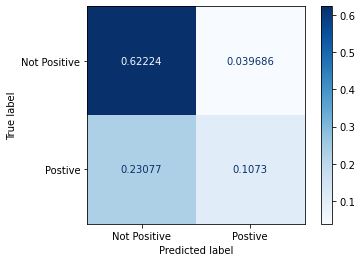

In [152]:
plot_confusion_matrix(pipe_cbc, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

### 5th Iteration: Neural Network with Regularization

In [98]:
#Sanity Check
X_train.head()

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight link band food art i...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...


In [99]:
# Sets the sets as a Series Object
X_train = X_train["Tweet"]
X_val = X_val["Tweet"]

In [100]:
#Sanity Check
print(type(X_train))
print(type(X_val))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [101]:
#How long is our longest tweet
max_length = max([len(tweet.split()) for tweet in X_train])
max_length

18

In [102]:
# Instatiate the Tokenizer
k_tokenizer = keras.preprocessing.text.Tokenizer()

#fit the tokenizer
k_tokenizer.fit_on_texts(X_train)

#
X_train_token = k_tokenizer.texts_to_sequences(X_train)
X_val_token = k_tokenizer.texts_to_sequences(X_val)

In [103]:
#pads the tweets for equal length
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [104]:
#checks word length list
vocab_size = len(k_tokenizer.word_index) + 1
maxlen= 100
print(vocab_size)

7137


Following Function can be found here : https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review

In [105]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

GloVE file to large for Git Hub, can be found here: https://nlp.stanford.edu/projects/glove/

In [106]:
#sets the embedding dimensions
embedding_dim = 50
embedding_matrix = create_embedding_matrix('notebooks/dave/glove.6B.50d.txt',
                                           k_tokenizer.word_index, 
                                           embedding_dim)

In [107]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.5))
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 50)            356850    
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dropout (Dropout)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 350)               315350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [108]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 4s 33ms/step - loss: 1.1492 - accuracy: 0.6708 - val_loss: 0.9029 - val_accuracy: 0.6644
Epoch 2/10
123/123 [==============================] - 3s 21ms/step - loss: 0.8381 - accuracy: 0.6782 - val_loss: 0.7780 - val_accuracy: 0.6854
Epoch 3/10
123/123 [==============================] - 3s 26ms/step - loss: 0.7582 - accuracy: 0.6894 - val_loss: 0.7387 - val_accuracy: 0.6717
Epoch 4/10
123/123 [==============================] - 6s 47ms/step - loss: 0.7120 - accuracy: 0.7059 - val_loss: 0.7037 - val_accuracy: 0.7085
Epoch 5/10
123/123 [==============================] - 5s 41ms/step - loss: 0.6942 - accuracy: 0.7144 - val_loss: 0.6961 - val_accuracy: 0.7080
Epoch 6/10
123/123 [==============================] - 5s 37ms/step - loss: 0.6702 - accuracy: 0.7314 - val_loss: 0.7067 - val_accuracy: 0.69436682 - ac
Epoch 7/10
123/123 [==============================] - 5s 39ms/step - loss: 0.6518 - accuracy: 0.7499 - val_loss: 0.6807 - val_accurac

In [109]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

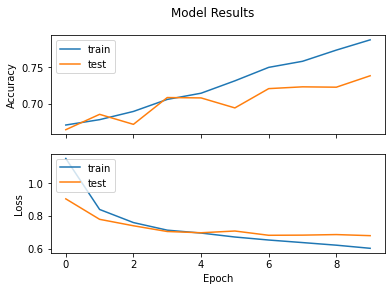

In [110]:
visualize_training_results(history)

## Evaluation

In [111]:
X_tr

,Tweet
233,Shouts to all the ladies holding up their iPad...
4022,Apple will be opening a temporary Apple Store ...
3438,Today's the day - join the Mobile Social ride ...
4597,I'm looking forward to our panel tomorrow (5pm...
8777,ProTip: Avoid the Austin-area Apple stores on ...
...,...
5734,RT @mention FREE #iTunes #SXSW ... link takes ...
5191,"RT @mention &quot;Transparency, choice and con..."
5390,RT @mention Anybody seen if the 6th St Apple s...
860,N33: They Love Me in This Town {link} [codes ...


In [112]:
X_test

,Tweet
5278,RT @mention #SXSW Come see Bitbop in Austin #g...
8080,12 #SXSW startup's elevator pitches in 12 minu...
6599,RT @mention RT @mention We interrupt your regu...
8206,Didn't get enough hacking on #startupbus? RSVP...
5244,RT @mention #Social Is Too Important For #Goog...
...,...
5883,RT @mention Google to Launch Major New Social ...
5710,RT @mention First day the exhibit hall is open...
637,Catch 22Û_ I mean iPad 2 at #SXSW - {link} #a...
3064,I21: No Rest for the Wicked {link} [codes vali...


In [114]:
X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))
X_tr['Tweet'] = X_tr['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_53124/4104971544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_53124/4104971544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['Tweet'] = X_tr['Tweet'].apply(lambda x: clean_tweets(x))


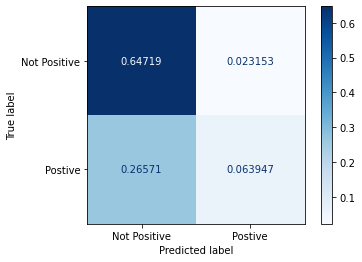

In [122]:
plot_confusion_matrix(pipe_nb_tuned, X_test["Tweet"], y_test, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "all")

In [124]:
pipe_nb_tuned.score(X_test["Tweet"], y_test)

0.7111356119073869